## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Generate Synthetic Sequence Data

We'll create a simple sequence prediction task: predict the next value in a sine wave.

Training data shape: torch.Size([800, 50, 1]), torch.Size([800, 1])
Test data shape: torch.Size([200, 50, 1]), torch.Size([200, 1])


/var/folders/d8/vmhmyn8d6w7ggh_d92mvg__w0000gp/T/ipykernel_82743/2426392126.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  return torch.FloatTensor(X).unsqueeze(-1), torch.FloatTensor(y).unsqueeze(-1)


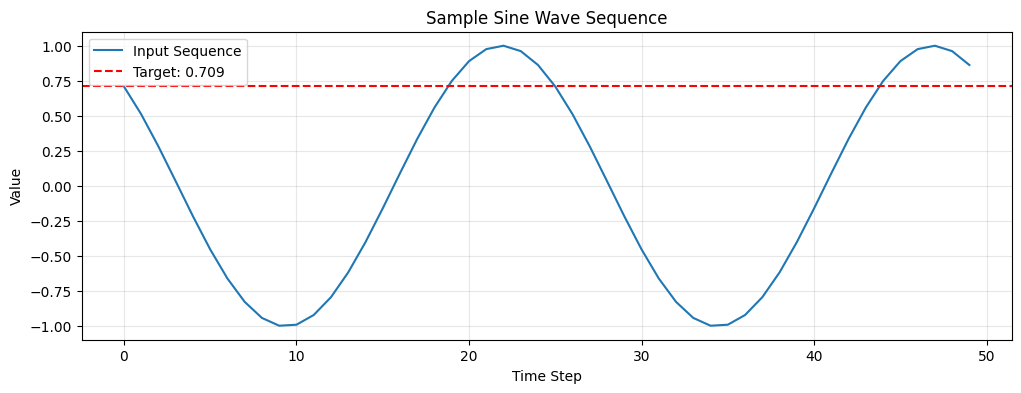

In [2]:
def generate_sine_data(seq_length=50, num_samples=1000):
    """Generate sine wave sequences"""
    X, y = [], []
    
    for _ in range(num_samples):
        start = np.random.rand() * 2 * np.pi
        t = np.linspace(start, start + 4*np.pi, seq_length + 1)
        sequence = np.sin(t)
        
        X.append(sequence[:-1])
        y.append(sequence[-1])
    
    return torch.FloatTensor(X).unsqueeze(-1), torch.FloatTensor(y).unsqueeze(-1)

# Generate data
X_train, y_train = generate_sine_data(seq_length=50, num_samples=800)
X_test, y_test = generate_sine_data(seq_length=50, num_samples=200)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

# Visualize sample
plt.figure(figsize=(12, 4))
plt.plot(X_train[0].numpy(), label='Input Sequence')
plt.axhline(y=y_train[0].item(), color='r', linestyle='--', label=f'Target: {y_train[0].item():.3f}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Sample Sine Wave Sequence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Define Models: RNN, LSTM, and GRU

In [3]:
class SimpleRNN(nn.Module):
    """Basic RNN for sequence prediction"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # x: [batch, seq_len, input_size]
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take last output
        return out


class SimpleLSTM(nn.Module):
    """LSTM for sequence prediction"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class SimpleGRU(nn.Module):
    """GRU for sequence prediction"""
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

print("✓ Models defined: RNN, LSTM, GRU")

✓ Models defined: RNN, LSTM, GRU


## 4. Training Function

In [4]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.001, batch_size=32):
    """Train a model and return training history"""
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    # Move data to device
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        
        # Mini-batch training
        total_loss = 0
        num_batches = len(X_train) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_losses.append(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}")
    
    training_time = time.time() - start_time
    
    return train_losses, test_losses, training_time

## 5. Train All Three Models

In [5]:
# Initialize models
rnn_model = SimpleRNN(hidden_size=64, num_layers=1)
lstm_model = SimpleLSTM(hidden_size=64, num_layers=1)
gru_model = SimpleGRU(hidden_size=64, num_layers=1)

print("Training RNN...")
rnn_train_loss, rnn_test_loss, rnn_time = train_model(rnn_model, X_train, y_train, X_test, y_test)

print("\nTraining LSTM...")
lstm_train_loss, lstm_test_loss, lstm_time = train_model(lstm_model, X_train, y_train, X_test, y_test)

print("\nTraining GRU...")
gru_train_loss, gru_test_loss, gru_time = train_model(gru_model, X_train, y_train, X_test, y_test)

print("\n" + "="*50)
print("Training Complete!")
print("="*50)

Training RNN...
Epoch [10/50], Train Loss: 0.000312, Test Loss: 0.000319
Epoch [20/50], Train Loss: 0.000044, Test Loss: 0.000033
Epoch [30/50], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [40/50], Train Loss: 0.000000, Test Loss: 0.000000
Epoch [50/50], Train Loss: 0.000000, Test Loss: 0.000000

Training LSTM...
Epoch [10/50], Train Loss: 0.000032, Test Loss: 0.000029
Epoch [20/50], Train Loss: 0.000002, Test Loss: 0.000002
Epoch [30/50], Train Loss: 0.000002, Test Loss: 0.000002
Epoch [40/50], Train Loss: 0.000001, Test Loss: 0.000001
Epoch [50/50], Train Loss: 0.000001, Test Loss: 0.000001

Training GRU...
Epoch [10/50], Train Loss: 0.000099, Test Loss: 0.000092
Epoch [20/50], Train Loss: 0.000043, Test Loss: 0.000042
Epoch [30/50], Train Loss: 0.000014, Test Loss: 0.000012
Epoch [40/50], Train Loss: 0.000002, Test Loss: 0.000001
Epoch [50/50], Train Loss: 0.000000, Test Loss: 0.000000

Training Complete!


## 6. Compare Training Performance

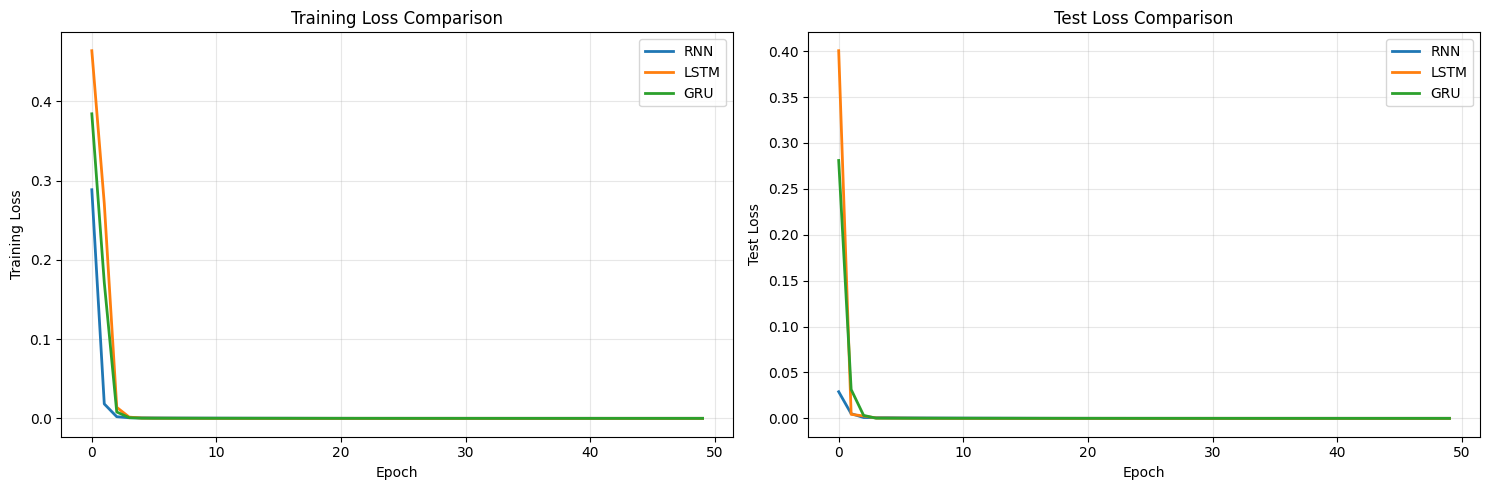

In [6]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
axes[0].plot(rnn_train_loss, label='RNN', linewidth=2)
axes[0].plot(lstm_train_loss, label='LSTM', linewidth=2)
axes[0].plot(gru_train_loss, label='GRU', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test loss
axes[1].plot(rnn_test_loss, label='RNN', linewidth=2)
axes[1].plot(lstm_test_loss, label='LSTM', linewidth=2)
axes[1].plot(gru_test_loss, label='GRU', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Loss')
axes[1].set_title('Test Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Performance Metrics Summary

In [7]:
import pandas as pd

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create summary table
summary_data = {
    'Model': ['RNN', 'LSTM', 'GRU'],
    'Final Train Loss': [rnn_train_loss[-1], lstm_train_loss[-1], gru_train_loss[-1]],
    'Final Test Loss': [rnn_test_loss[-1], lstm_test_loss[-1], gru_test_loss[-1]],
    'Training Time (s)': [rnn_time, lstm_time, gru_time],
    'Parameters': [count_parameters(rnn_model), count_parameters(lstm_model), count_parameters(gru_model)]
}

df = pd.DataFrame(summary_data)
df['Final Train Loss'] = df['Final Train Loss'].map('{:.6f}'.format)
df['Final Test Loss'] = df['Final Test Loss'].map('{:.6f}'.format)
df['Training Time (s)'] = df['Training Time (s)'].map('{:.2f}'.format)

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(df.to_string(index=False))
print("="*70)


PERFORMANCE COMPARISON
Model Final Train Loss Final Test Loss Training Time (s)  Parameters
  RNN         0.000000        0.000000              4.38        4353
 LSTM         0.000001        0.000001             11.98       17217
  GRU         0.000000        0.000000             11.74       12929


## 8. Visualize Predictions

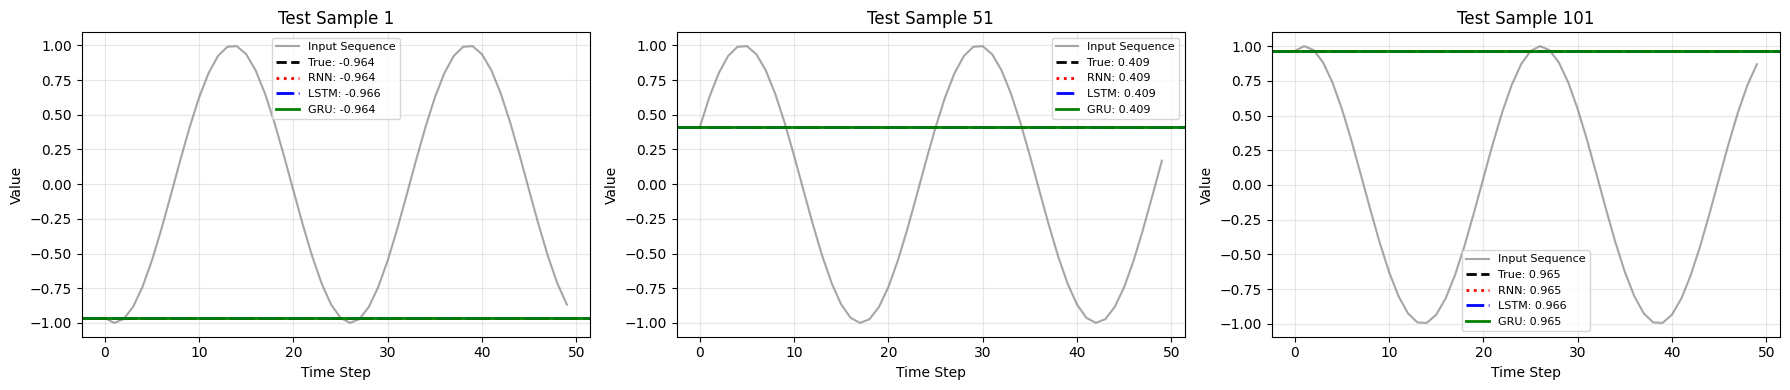

In [8]:
# Test on sample sequences
rnn_model.eval()
lstm_model.eval()
gru_model.eval()

with torch.no_grad():
    sample_indices = [0, 50, 100]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    for idx, sample_idx in enumerate(sample_indices):
        sample_input = X_test[sample_idx:sample_idx+1].to(device)
        true_value = y_test[sample_idx].item()
        
        rnn_pred = rnn_model(sample_input).cpu().item()
        lstm_pred = lstm_model(sample_input).cpu().item()
        gru_pred = gru_model(sample_input).cpu().item()
        
        # Plot sequence and predictions
        axes[idx].plot(X_test[sample_idx].cpu().numpy(), label='Input Sequence', color='gray', alpha=0.7)
        axes[idx].axhline(y=true_value, color='black', linestyle='--', linewidth=2, label=f'True: {true_value:.3f}')
        axes[idx].axhline(y=rnn_pred, color='red', linestyle=':', linewidth=2, label=f'RNN: {rnn_pred:.3f}')
        axes[idx].axhline(y=lstm_pred, color='blue', linestyle='-.', linewidth=2, label=f'LSTM: {lstm_pred:.3f}')
        axes[idx].axhline(y=gru_pred, color='green', linestyle='-', linewidth=2, label=f'GRU: {gru_pred:.3f}')
        
        axes[idx].set_title(f'Test Sample {sample_idx + 1}')
        axes[idx].set_xlabel('Time Step')
        axes[idx].set_ylabel('Value')
        axes[idx].legend(loc='best', fontsize=8)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Architecture Comparison

### Key Differences:

#### **RNN (Recurrent Neural Network)**
- **Gates:** None
- **Parameters:** Fewest (fastest training)
- **Memory:** Short-term only
- **Problem:** Vanishing/exploding gradients
- **Best for:** Short sequences (<10 steps)

#### **LSTM (Long Short-Term Memory)**
- **Gates:** 3 gates (input, forget, output)
- **Parameters:** Most (4× weight matrices)
- **Memory:** Long-term via cell state
- **Advantage:** Solves vanishing gradient problem
- **Best for:** Long sequences, complex dependencies

#### **GRU (Gated Recurrent Unit)**
- **Gates:** 2 gates (reset, update)
- **Parameters:** Fewer than LSTM (3× weight matrices)
- **Memory:** Similar to LSTM but simpler
- **Advantage:** Faster training than LSTM, similar performance
- **Best for:** Balance between RNN and LSTM

## 10. Limitations Demonstrated

Let's test on longer sequences to show RNN's limitations:


PERFORMANCE ON LONGER SEQUENCES (100 steps)
RNN MSE:  0.073527  
LSTM MSE: 0.293175
GRU MSE:  0.042267


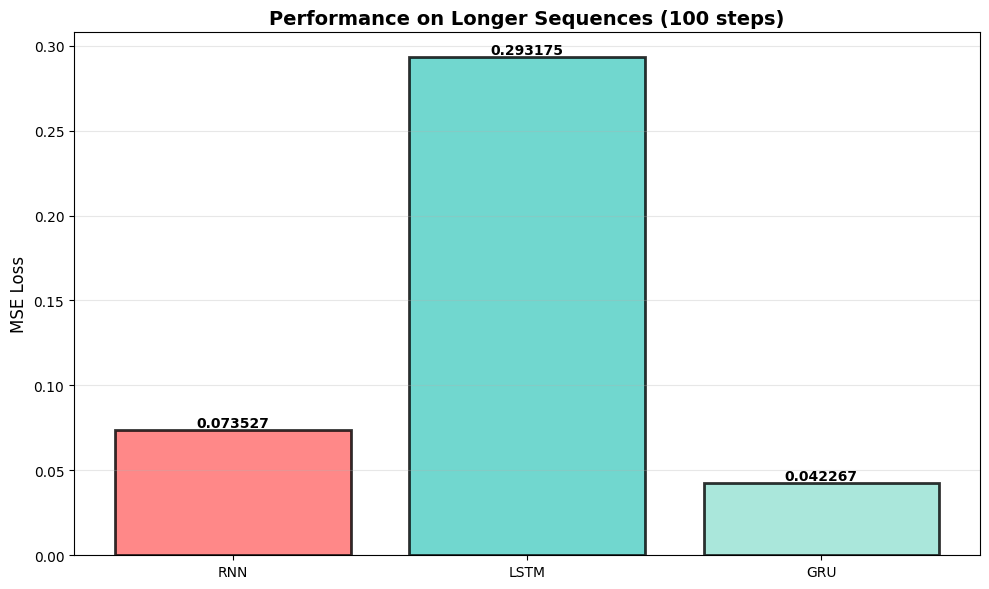

In [9]:
# Generate longer sequences
X_long, y_long = generate_sine_data(seq_length=100, num_samples=200)

# Test models on longer sequences
rnn_model.eval()
lstm_model.eval()
gru_model.eval()

with torch.no_grad():
    X_long_device = X_long.to(device)
    y_long_device = y_long.to(device)
    
    rnn_preds = rnn_model(X_long_device)
    lstm_preds = lstm_model(X_long_device)
    gru_preds = gru_model(X_long_device)
    
    rnn_mse = nn.MSELoss()(rnn_preds, y_long_device).item()
    lstm_mse = nn.MSELoss()(lstm_preds, y_long_device).item()
    gru_mse = nn.MSELoss()(gru_preds, y_long_device).item()

print("\n" + "="*50)
print("PERFORMANCE ON LONGER SEQUENCES (100 steps)")
print("="*50)
print(f"RNN MSE:  {rnn_mse:.6f}  {'⚠️ Degrades significantly!' if rnn_mse > lstm_mse * 1.5 else ''}")
print(f"LSTM MSE: {lstm_mse:.6f}")
print(f"GRU MSE:  {gru_mse:.6f}")
print("="*50)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
models = ['RNN', 'LSTM', 'GRU']
mse_values = [rnn_mse, lstm_mse, gru_mse]
colors = ['#ff6b6b', '#4ecdc4', '#95e1d3']

bars = ax.bar(models, mse_values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Performance on Longer Sequences (100 steps)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, mse_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.6f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Summary & Recommendations

### When to Use Each:

| Scenario | Recommended Model | Reason |
|----------|------------------|--------|
| Short sequences (<20 steps) | **RNN** | Faster training, sufficient capacity |
| Long sequences (>50 steps) | **LSTM** | Better long-term memory |
| Medium sequences (20-50 steps) | **GRU** | Good balance of speed and performance |
| Limited computational resources | **GRU** | Fewer parameters than LSTM |
| Complex long-term dependencies | **LSTM** | Most powerful memory mechanism |
| Real-time applications | **GRU or RNN** | Faster inference |

### Key Takeaways:

1. **RNN**: Simple but struggles with long sequences due to vanishing gradients
2. **LSTM**: Solves vanishing gradient with gating mechanisms (3 gates)
3. **GRU**: Simpler alternative to LSTM with fewer parameters (2 gates)
4. **Performance**: LSTM ≈ GRU > RNN for most sequence tasks
5. **Speed**: RNN > GRU > LSTM
6. **Modern Alternative**: Transformers (parallel processing, no recurrence)

## 12. Why Transformers?

Despite LSTM and GRU improvements, they still have limitations:

- ⚠️ **Sequential Processing**: Cannot parallelize across time steps
- ⚠️ **Long Sequences**: Still struggle with very long dependencies (>500 steps)
- ⚠️ **Training Speed**: Slow on modern hardware (GPUs/TPUs)
- ⚠️ **Information Bottleneck**: Hidden state must compress all history

**Transformers solve these issues with:**
- ✅ Attention mechanism (direct connections between all positions)
- ✅ Parallel processing (all positions computed simultaneously)
- ✅ No vanishing gradients (constant path length)
- ✅ Scalability (efficient on modern hardware)